# 0. Setup

In [1]:
from datasets import load_dataset
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import os
import polars as pl
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

pl.Config.set_tbl_cols(100)

from library.eda.splits_plot import plot_splits
from library.eda.wordclouds import plot_wordclouds

c:\Users\blanc\miniconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Swiss Judgement Prediction

Our dataset is the following: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

It contains 85,274 texts from cases that reached the Swiss Federal Supreme Court. Specifically, it contains the extract of text with the facts of the case. Each row is labeled according to whether the case was dismissed or approved (0 and 1, respectively). 

The texts are in the three official languages of the country, German, French and Italian. We explore possibilities for translation below. 

The dataset has the following columns:ç
* `id`: a unique identifier for each case
* `year`: (int) the publication year of the sentence
* `text`: (str) the facts of the case
* `label`: (class label) the judgment outcome: 0 (dismissal) or 1 (approval)
* `language`: (str) identifying the actuall language of the text: de, fr, it or en (when the text is translated)
* `source_language`: (str) the original language (de, fr, it) when the text has been translated (meaning, when language == en)
* `region`: (str) the region of the court that tried the original case (called the lower court)
* `canton`: (str) the canton of the lower court
* `legal area`: (str) the legal area of the case

In [2]:
# Load original dataset (with the original languages)
swiss = load_dataset('swiss_judgment_prediction', 'all', trust_remote_code=True)

In [3]:
print(swiss)

DatasetDict({
    train: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 59709
    })
    validation: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 8208
    })
    test: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 17357
    })
})


In [4]:
# EXAMPLE
pprint(swiss['train'][4])

{'canton': 'n/a',
 'id': 6,
 'label': 0,
 'language': 'de',
 'legal area': 'civil law',
 'region': 'n/a',
 'source_language': 'n/a',
 'text': 'Mietvertrag, hat sich ergeben: A.- Die CT Condor Treuhand AG '
         'vermietete vom 1. April 1987 bis 31. Dezember 1993 Büroräume an der '
         'Hinterbergstrasse 26 in Cham an Andreas Rohrer. Mit Vertrag vom 4. '
         'November 1993 schloss sie mit Andreas Rohrer und Thomas Ulrich einen '
         'neuen Mietvertrag auf unbestimmte Zeit über Büroräumlichkeiten an '
         'der selben Adresse. Mietbeginn war der 1. Januar 1994; der Mietzins '
         "betrug Fr. 3'060.-- monatlich inklusive Nebenkosten. Am 17. Januar "
         '1995 ersetzten die Parteien diesen Vertrag per 1. Februar 1995 durch '
         'einen neuen Mietvertrag, worin u.a. der monatliche Mietzins neu auf '
         "Fr. 2'800.-- zuzüglich Mehrwertsteuer festgesetzt wurde. Dieses "
         'Mietverhältnis wurde per 31. Juli 1997 aufgelöst. B.- Mit Klage vom '


In [5]:
train = swiss['train'].to_dict()
valid = swiss['validation'].to_dict()
test = swiss['test'].to_dict()

# Convert to Polars DataFrame
train_full, valid_full, test_full = pl.DataFrame(train), pl.DataFrame(valid), pl.DataFrame(test)

# Now you can do data exploration
print(train_full.head())
print(train_full.shape, valid_full.shape, test_full.shape)


shape: (5, 9)
┌─────┬──────┬──────────────┬───────┬──────────┬──────────────┬────────┬─────────────┬─────────────┐
│ id  ┆ year ┆ text         ┆ label ┆ language ┆ region       ┆ canton ┆ legal area  ┆ source_lang │
│ --- ┆ ---  ┆ ---          ┆ ---   ┆ ---      ┆ ---          ┆ ---    ┆ ---         ┆ uage        │
│ i64 ┆ i64  ┆ str          ┆ i64   ┆ str      ┆ str          ┆ str    ┆ str         ┆ ---         │
│     ┆      ┆              ┆       ┆          ┆              ┆        ┆             ┆ str         │
╞═════╪══════╪══════════════╪═══════╪══════════╪══════════════╪════════╪═════════════╪═════════════╡
│ 2   ┆ 2000 ┆ A.- Der 1955 ┆ 0     ┆ de       ┆ Zürich       ┆ zh     ┆ insurance   ┆ n/a         │
│     ┆      ┆ geborene V._ ┆       ┆          ┆              ┆        ┆ law         ┆             │
│     ┆      ┆ war …        ┆       ┆          ┆              ┆        ┆             ┆             │
│ 3   ┆ 2000 ┆ Ansprüche    ┆ 1     ┆ de       ┆ Central      ┆ lu     ┆ publ

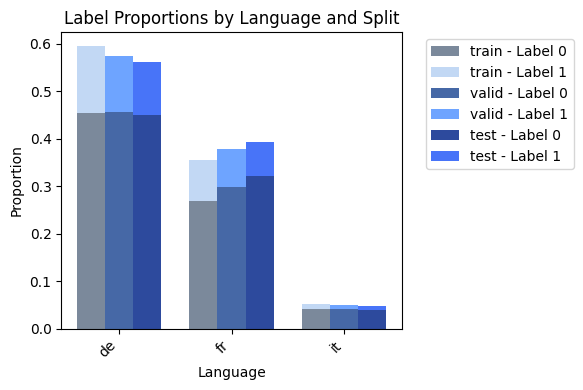

In [6]:
plot_splits(train_full, valid_full, test_full, group_col="language", figsize=(6, 4))

## Exploring English translation

This dataset has available a version with an English translation of all documents, which we can import by setting the second hyperparameter to `'all+mt'` (all languages + machine translation). We explore this as a possibility so we can work with texts in English.

In [7]:
swiss_trans = load_dataset('swiss_judgment_prediction', 'all+mt', trust_remote_code=True)

In [8]:
pprint(swiss_trans['train'].filter(lambda x: x['language'] == 'en')[0])

{'canton': 'sg',
 'id': 2,
 'label': 1,
 'language': 'en',
 'legal area': 'insurance law',
 'region': 'Eastern Switzerland',
 'source_language': 'de',
 'text': 'A. The 1945-born S._ signed on the 20th. In January 1997, the '
         'Invalid Insurance due to pain in the back, neck and right leg to the '
         'service transfer. The fourth place of St. Gallen took among other '
         'things. Doctors from Dr. L. 1. April 1997 as well as Dr. H._, head '
         'doctor of the Clinic for Neurosurgery, Canton Hospital X._, of 29. '
         'October 1996, 9 and 20. in June 1997. On the basis of this, the '
         'IV-point refused the right to a disability pension (arrest of 4. in '
         'August 1997). B. The Court of Justice of the Canton. Decision of '
         '17th. September 1999 good, he raised the order from 4. In August '
         '1997, the case was submitted back to the IV position, so that it '
         'understood in the sense of the considerations and then regain

We can see that the translation is really bad. We consider some translation APIs that we could use:

1. DeepL: https://www.deepl.com/en/pro#developer (5€ per month + €20.00 per 1.000.000 characters)
2. Google Cloud Translation API (Google Translate API): https://cloud.google.com/translate/docs ($300 free credit, but after that very expensive)
3. Libre translate (free translator, but doesn't work very well): https://libretranslate.com/

However, our number of characters:

In [9]:
def count_total_characters(data):
    return sum(len(item['text']) for item in data)

# Training set character count
total_characters_train = count_total_characters(swiss['train'])
print(f"Total characters: {total_characters_train:,}")

# Validation set character count
total_characters_validation = count_total_characters(swiss['validation'])
print(f"Total characters: {total_characters_validation:,}")

# Test set character count
total_characters_test = count_total_characters(swiss['test'])
print(f"Total characters: {total_characters_test:,}")

# Number of total instances in all sets
total_characters = total_characters_train + total_characters_validation + total_characters_test
print(f"Total characters in all sets: {total_characters:,}")

Total characters: 203,219,455
Total characters: 25,056,077
Total characters: 59,217,191
Total characters in all sets: 287,492,723


Even if we translated only the French texts which represent around 35% of the total (Italian set is too small and German set is even larger) we would have to translate around 100 million tokens.

Because of this reason, we choose to only use the French and Italian subset, as those are the languages that we can better understand. 

In [10]:
train_filtered = train_full.filter(pl.col('language') != 'de')
valid_filtered = valid_full.filter(pl.col('language') != 'de')
test_filtered = test_full.filter(pl.col('language') != 'de')

## Exploring null values and class distribution

In [11]:
dfs = []
for df in [train_filtered, valid_filtered, test_filtered]:
    df = df.with_columns([pl.when(pl.col(col) == 'n/a')
                          .then(None)
                          .otherwise(pl.col(col))
                            .alias(col) for col in df.columns
                            if df[col].dtype == pl.Utf8])
    dfs.append(df)

train_filtered, valid_filtered, test_filtered = dfs
    
print(train_filtered.null_count())
print(valid_filtered.null_count())
print(test_filtered.null_count())

shape: (1, 9)
┌─────┬──────┬──────┬───────┬──────────┬────────┬────────┬────────────┬─────────────────┐
│ id  ┆ year ┆ text ┆ label ┆ language ┆ region ┆ canton ┆ legal area ┆ source_language │
│ --- ┆ ---  ┆ ---  ┆ ---   ┆ ---      ┆ ---    ┆ ---    ┆ ---        ┆ ---             │
│ u32 ┆ u32  ┆ u32  ┆ u32   ┆ u32      ┆ u32    ┆ u32    ┆ u32        ┆ u32             │
╞═════╪══════╪══════╪═══════╪══════════╪════════╪════════╪════════════╪═════════════════╡
│ 0   ┆ 0    ┆ 0    ┆ 0     ┆ 0        ┆ 5436   ┆ 5436   ┆ 0          ┆ 24251           │
└─────┴──────┴──────┴───────┴──────────┴────────┴────────┴────────────┴─────────────────┘
shape: (1, 9)
┌─────┬──────┬──────┬───────┬──────────┬────────┬────────┬────────────┬─────────────────┐
│ id  ┆ year ┆ text ┆ label ┆ language ┆ region ┆ canton ┆ legal area ┆ source_language │
│ --- ┆ ---  ┆ ---  ┆ ---   ┆ ---      ┆ ---    ┆ ---    ┆ ---        ┆ ---             │
│ u32 ┆ u32  ┆ u32  ┆ u32   ┆ u32      ┆ u32    ┆ u32    ┆ u32        ┆ 

In [12]:
train_null_prc = train_filtered.null_count()['region'][0] / train_full.shape[0]
valid_null_prc = valid_filtered.null_count()['region'][0] / valid_full.shape[0] 
test_null_prc = test_filtered.null_count()['region'][0] / test_full.shape[0]

print(f"Train nulls: {train_null_prc:.2%}\nValid nulls: {valid_null_prc:.2%}\nTest nulls: {test_null_prc:.2%}")

Train nulls: 9.10%
Valid nulls: 4.18%
Test nulls: 4.50%


We only have nulls in the region and canton columns, same number for both columns, which represent the percentages above for each of the splits. For now we will keep all of the rows, as our predictor will be the text and these proportions are very small. 

The nulls in the source column (for all rows) are there because we are not dealing with translated text. We will dispose of this column shortly.

Next, we explore the class distribution.

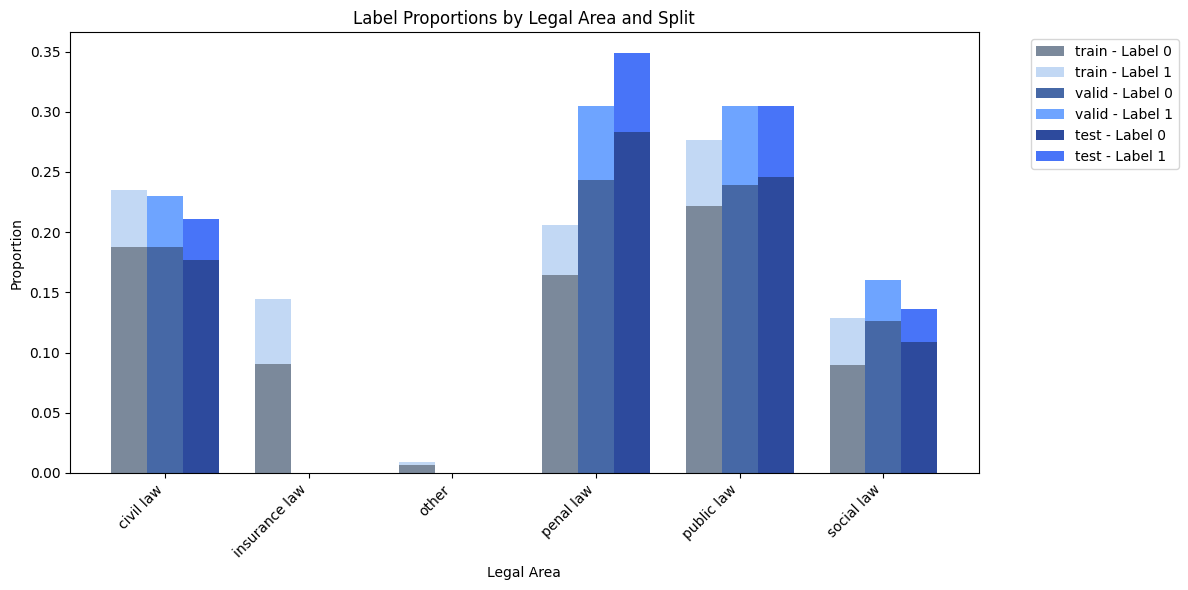

In [13]:
plot_splits(train_filtered, valid_filtered, test_filtered, group_col="legal area")

The legal area distribution accross splits (the ones pre-set when we downloaded the dataset) is very unequal. 

While the column with the legal area value will not be a predictor, the type of language contained in the facts of cases accross different legal areas will probably be greatly different, so we want this distribution to be as equal as possible. 

For this reason, we shuffle the dataset and make the splits again, respecting the original proportions.

In [14]:
n_train, n_valid, n_test = train_filtered.shape[0], valid_filtered.shape[0], valid_filtered.shape[0]
n_total = n_train + n_valid + n_test
p_train, p_valid, p_test = n_train / n_total, n_valid / n_total, n_test / n_total
print(f"Train: {n_train} ({p_train:.2%})\nValid: {n_valid} ({p_valid:.2%})\nTest: {n_test} ({p_test:.2%})")

Train: 24251 (77.59%)
Valid: 3503 (11.21%)
Test: 3503 (11.21%)


We save the shuffled datasets and we work with the imported versions from now on, to avoid changing distributions from the randomness of the shuffle. 

In [15]:
# # # COMBINING ALL THE SPLITS
# df = pl.concat([pl.DataFrame(train), pl.DataFrame(valid), pl.DataFrame(test)]) # dictionaries from before

# # SHUFFLING
# df = df.sample(fraction=1.0, with_replacement=False, shuffle=True, seed=42)
# df_filtered = df.filter(pl.col('language') != 'de')

# # SPLITTING
# train_df = df_filtered[:n_train]
# valid_df = df_filtered[n_train:n_train + n_valid]
# test_df  = df_filtered[n_train + n_valid:n_total]

# # SAVE FILES
# os.makedirs('data', exist_ok=True)

# train_df.write_parquet('data/swiss_judgment_prediction_train.parquet')
# valid_df.write_parquet('data/swiss_judgment_prediction_valid.parquet')
# test_df.write_parquet('data/swiss_judgment_prediction_test.parquet')

# IMPORT AGAIN
train_df = pl.read_parquet('data/swiss_judgment_prediction_train.parquet')
valid_df = pl.read_parquet('data/swiss_judgment_prediction_valid.parquet')
test_df = pl.read_parquet('data/swiss_judgment_prediction_test.parquet')

print(train_df.shape, valid_df.shape, test_df.shape)

(24251, 9) (3503, 9) (3503, 9)


**NEW DISTRIBUTIONS**

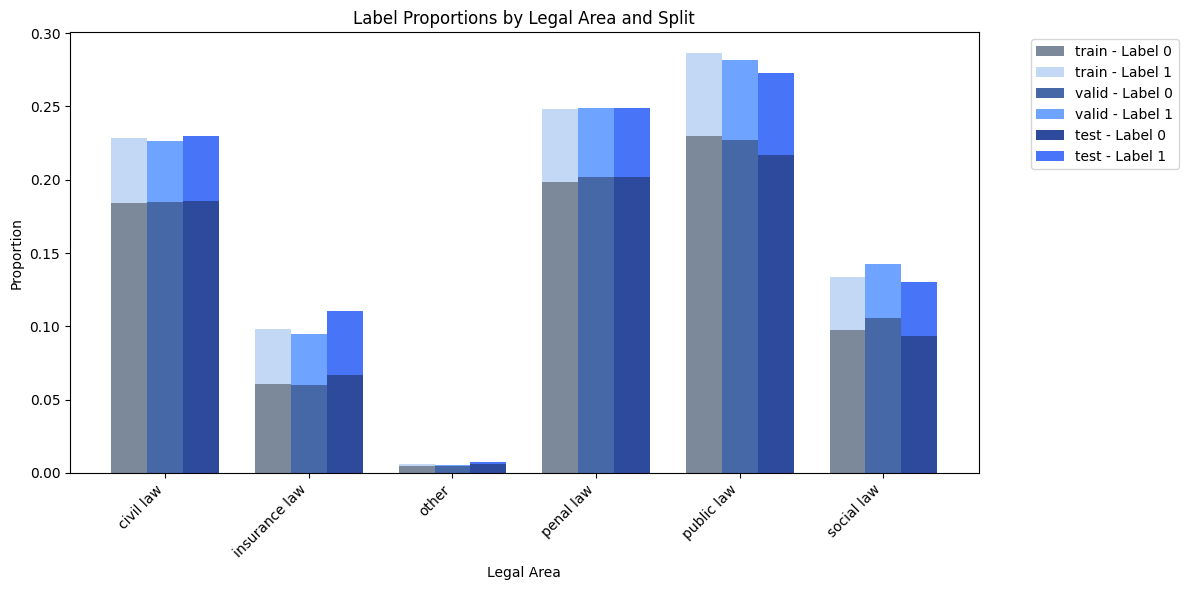

In [16]:
plot_splits(train_df, valid_df, test_df, group_col="legal area")

## Exploring language distribution

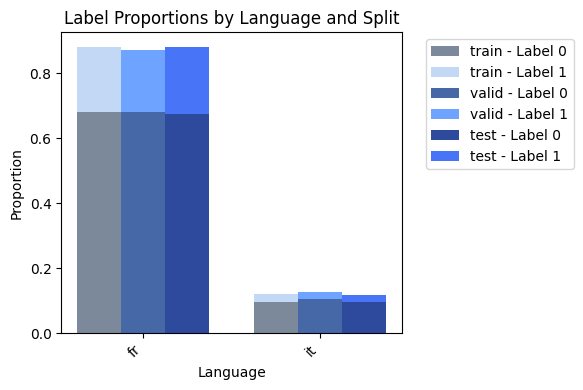

COUNT AND PROPORTIONS IN TRAIN SET:
     French: 21,354 (88.05%)
     Italian: 2,897 (11.95%)


In [17]:
plot_splits(train_df, valid_df, test_df, group_col="language", figsize=(6, 4))

lang_counts = (
    train_df.select(pl.col("language"))
    .to_series()
    .value_counts()
    .sort("language")  # Ensure consistent order
)

fr_n = lang_counts.filter(pl.col("language") == "fr")["count"][0]
it_n = lang_counts.filter(pl.col("language") == "it")["count"][0]
fr_p = fr_n / n_train
it_p = it_n / n_train

print('COUNT AND PROPORTIONS IN TRAIN SET:')
print(f'     French: {fr_n:,} ({fr_p:.2%})')
print(f'     Italian: {it_n:,} ({it_p:.2%})')

In [18]:
val_lang_counts = (valid_df.select(pl.col("language")).to_series().value_counts().sort("language"))
test_df_lang_counts = (test_df.select(pl.col("language")).to_series().value_counts().sort("language"))

fr_train_1 = train_df.filter((pl.col('label') == 1) & (pl.col('language') == 'fr')).height
fr_train_0 = train_df.filter((pl.col('label') == 0) & (pl.col('language') == 'fr')).height
it_train_1 = train_df.filter((pl.col('label') == 1) & (pl.col('language') == 'it')).height
it_train_0 = train_df.filter((pl.col('label') == 0) & (pl.col('language') == 'it')).height

fr_valid_1 = valid_df.filter((pl.col('label') == 1) & (pl.col('language') == 'fr')).height
fr_valid_0 = valid_df.filter((pl.col('label') == 0) & (pl.col('language') == 'fr')).height
it_valid_1 = valid_df.filter((pl.col('label') == 1) & (pl.col('language') == 'it')).height
it_valid_0 = valid_df.filter((pl.col('label') == 0) & (pl.col('language') == 'it')).height

fr_test_1 = test_df.filter((pl.col('label') == 1) & (pl.col('language') == 'fr')).height
fr_test_0 = test_df.filter((pl.col('label') == 0) & (pl.col('language') == 'fr')).height
it_test_1 = test_df.filter((pl.col('label') == 1) & (pl.col('language') == 'it')).height
it_test_0 = test_df.filter((pl.col('label') == 0) & (pl.col('language') == 'it')).height

fr_train_1_prc = (fr_train_1 / (fr_train_1 + fr_train_0)) * 100
it_train_1_prc = (it_train_1 / (it_train_1 + it_train_0)) * 100
fr_valid_1_prc = (fr_valid_1 / (fr_valid_1 + fr_valid_0)) * 100
it_valid_1_prc = (it_valid_1 / (it_valid_1 + it_valid_0)) * 100 
fr_test_1_prc = (fr_test_1 / (fr_test_1 + fr_test_0)) * 100
it_test_1_prc = (it_test_1 / (it_test_1 + it_test_0)) * 100

print('-------- CLASS PROPORTIONS --------')
print('--- positive (1) vs negative (0) ---')
print('TRAIN:')
print(f'  French:  {fr_train_1_prc:.2f}% vs {100 - fr_train_1_prc:.2f}%')
print(f'  Italian: {it_train_1_prc:.2f}% vs {100 - it_train_1_prc:.2f}%')
print('VALIDATION:')    
print(f'  French:  {fr_valid_1_prc:.2f}% vs {100 - fr_valid_1_prc:.2f}%')
print(f'  Italian: {it_valid_1_prc:.2f}% vs {100 - it_valid_1_prc:.2f}%')
print('TEST:')
print(f'  French:  {fr_test_1_prc:.2f}% vs {100 - fr_test_1_prc:.2f}%')
print(f'  Italian: {it_test_1_prc:.2f}% vs {100 - it_test_1_prc:.2f}%')

-------- CLASS PROPORTIONS --------
--- positive (1) vs negative (0) ---
TRAIN:
  French:  22.80% vs 77.20%
  Italian: 19.74% vs 80.26%
VALIDATION:
  French:  22.15% vs 77.85%
  Italian: 18.12% vs 81.88%
TEST:
  French:  23.49% vs 76.51%
  Italian: 19.95% vs 80.05%


------------------------- FRENCH -------------------------


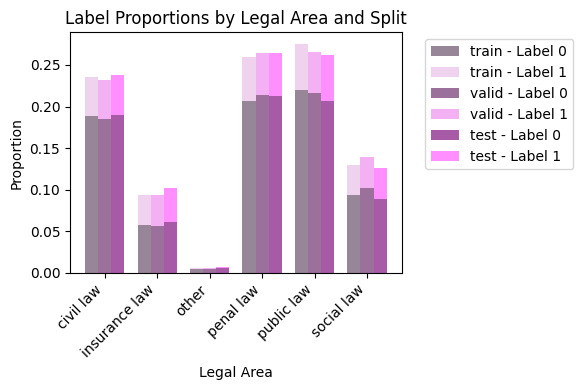

------------------------- ITALIAN -------------------------


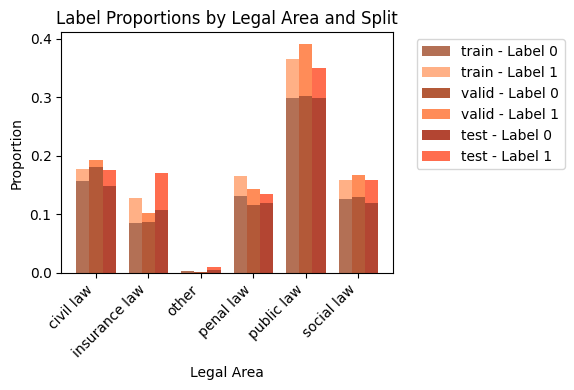

In [19]:
fr_train_df, it_train_df = train_df.filter(pl.col("language") == "fr"), train_df.filter(pl.col("language") == "it")
fr_valid_df, it_valid_df = valid_df.filter(pl.col("language") == "fr"), valid_df.filter(pl.col("language") == "it")
fr_test_df, it_test_df = test_df.filter(pl.col("language") == "fr"), test_df.filter(pl.col("language") == "it")

fr_colors = {"train": mcolors.CSS4_COLORS["thistle"],
            "valid": mcolors.CSS4_COLORS["plum"],
            "test": mcolors.CSS4_COLORS["violet"]
            }

it_colors = {"train": mcolors.CSS4_COLORS["lightsalmon"],
            "valid": mcolors.CSS4_COLORS["coral"],
            "test": mcolors.CSS4_COLORS["tomato"]
            }

print(f'-' * 25, 'FRENCH', '-' * 25)
plot_splits(fr_train_df, fr_valid_df, fr_test_df, fr_colors, group_col="legal area", figsize=(6, 4))
print(f'-' * 25, 'ITALIAN', '-' * 25)
plot_splits(it_train_df, it_valid_df, it_test_df, it_colors, group_col="legal area", figsize=(6, 4))

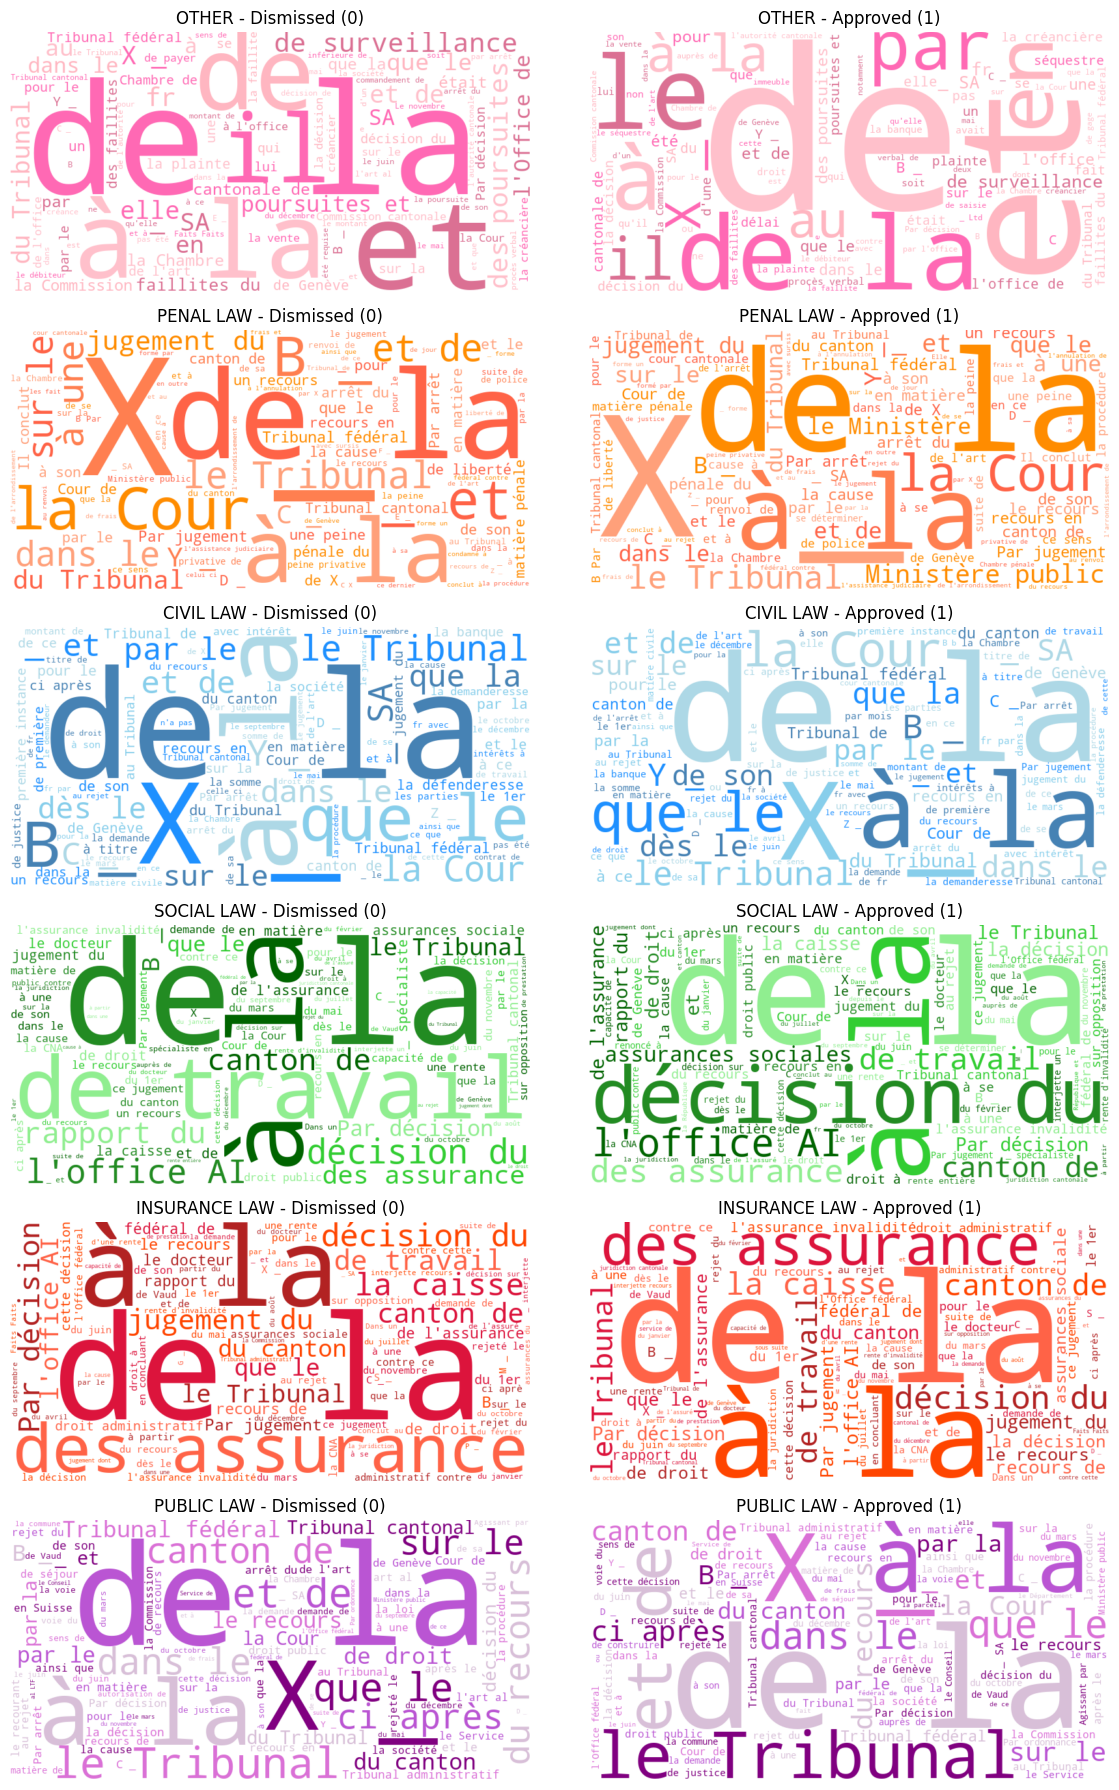

In [20]:
extra_stopwords = {'de', 'la', 'à', 'X', '_'}
plot_wordclouds(train_df, category_col='legal area', additional_stopwords=extra_stopwords)

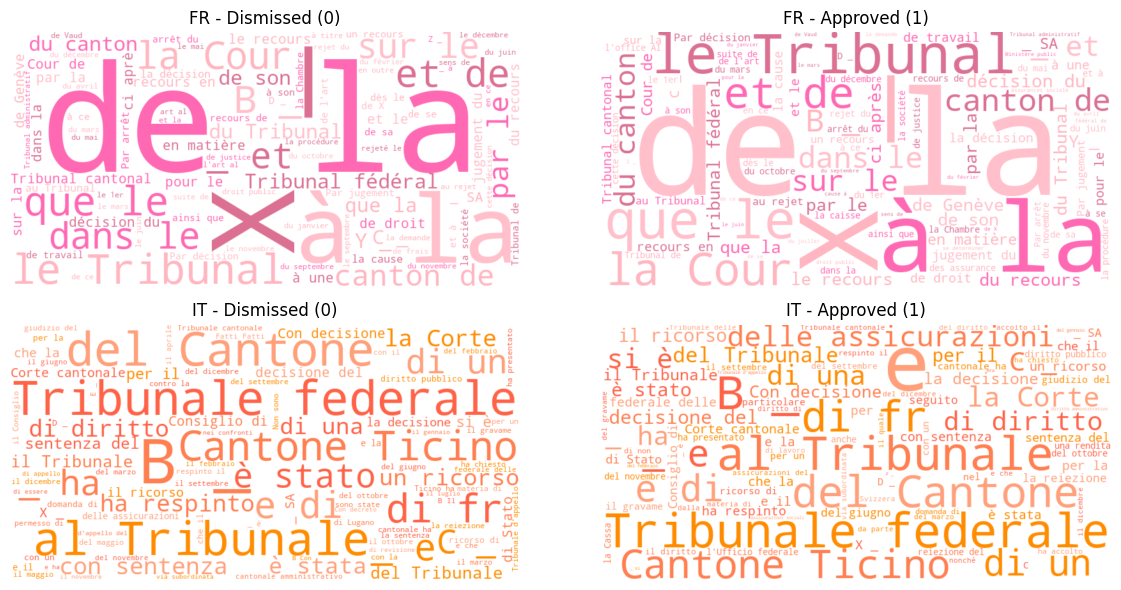

In [21]:
plot_wordclouds(train_df, category_col='language', additional_stopwords=extra_stopwords)

We are now left with a huge imbalance between French and Italian texts. This could negatively impact performance on model training by causing it to shift its focus onto French-text features largely and, therefore, not learning how to classify Italian texts as well. We can see from the wordclouds that word distribution changes greatly between the two languages with Italian exhibiting a much more uniform distribution. This would result in worse overall performance of our model, coming from bad performance on the Italian data.

It can also cause the model to indirectly use language as a predicting feature, especially seeing above that the positive-class proportion in Italian is slighly lower for all splits. And while this consistency might make this a helpful feature for our particular set of data, it would reduce our model's scalability to real-life applications. 

In fact, if we think about real-life applications, subtle cultural differences and behaviour patterns within different language speakers accross Switzerland might affect judicial decisions and writing style of legal system workers, so it is probably a wise decision to train a model on each language subset. 

For these reasons, we decide to also drpo the Italian rows. We will focus solely on the French texts. 

In [24]:
train_df = train_df.filter(pl.col('language') != 'it')
valid_df = valid_df.filter(pl.col('language') != 'it')
test_df = test_df.filter(pl.col('language') != 'it')

train_df.write_parquet('data/FRENCH_swiss_judgment_prediction_train.parquet')
valid_df.write_parquet('data/FRENCH_swiss_judgment_prediction_valid.parquet')
test_df.write_parquet('data/FRENCH_swiss_judgment_prediction_test.parquet')